In [1]:
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy as sp
import yfinance as yf
import os

from dotenv import load_dotenv

from statsmodels.stats.stattools import durbin_watson as dw_test
from statsmodels.graphics.tsaplots import plot_acf


In [2]:

load_dotenv()
fred_api_key = os.getenv('FRED_API_KEY')
from fredapi import Fred
fred = Fred(api_key=fred_api_key)

# <font face="gotham" color="purple"> What is Autocorrelation? </font>

Recall that a classical linear regression model 
$$
Y_t = \beta_1 +\beta_2 X_t +u_t
$$

has an assumption
$$
E\left(u_{i} u_{j}\right)=0 \quad i \neq j
$$
i.e. disturbance terms are independent of each other. However, in many real situations, this assumption will not hold, especially in time series data. Many economic or financial time series data has a 'momentum', for instance, if we see a boost in consumer confidence in this month, it is more likely continue the momentum next month unless something unexpected happens. 

However if this assumption is violated, we have **autocorrelation** issue
$$
E\left(u_{i} u_{j}\right)\neq 0 \quad i \neq j
$$
There are many reasons why autocorrelation exists, but for now we don't care about the exact reason.

If we say a series is **positively autocorrelated**, it means correlation between successive values are positive, vice verse we call it **negatively autorrelated**. In financial context, we say that positive autocorrelation is **trend following**(momentum), the negative autocorrelation is **mean reverting**.

For instance, weekly return of Microsoft (MSFT) has a negative autocorrelation, which means the possibility of mean-reverting trading strategy.

In [3]:
start = dt.datetime(2012, 1, 1)
stock = yf.download("MSFT", start=start)["Adj Close"].pct_change()
stock_weekly = stock.resample("W").last()

[*********************100%%**********************]  1 of 1 completed


In [4]:
stock_weekly.autocorr()

-0.07145398624533127

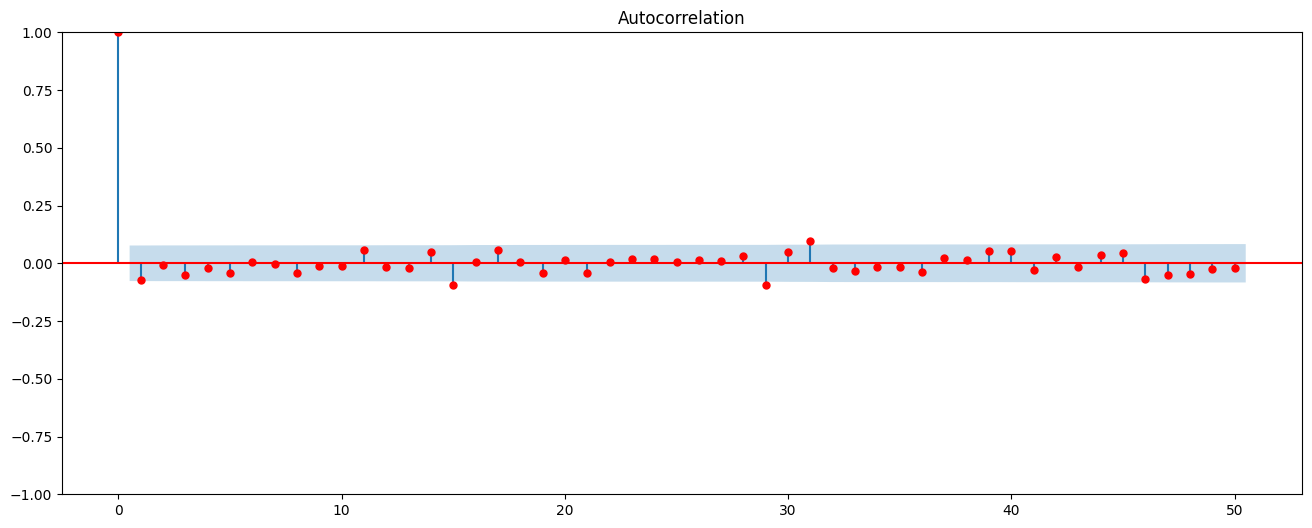

In [5]:
g = plot_acf(stock_weekly, lags=50, color="red").set_size_inches(16, 6)

What about interest rate, let's try with 10 year treasury yield.

In [6]:
start = dt.datetime(1950, 1, 1)
tr10_yield = yf.download("^TNX", start=start)["Adj Close"].dropna()
tr10_yield.diff().autocorr()

[*********************100%%**********************]  1 of 1 completed


0.06290619628423107

In [7]:
tr10_yield_annual = tr10_yield.resample("A").last().diff().dropna()
tr10_yield_annual.autocorr()

/tmp/ipykernel_215000/2352089167.py:1: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  tr10_yield_annual = tr10_yield.resample("A").last().diff().dropna()


-0.18313492055652775

We can see that interest rate has considerably high negative correlation at the annual change rate, but not the daily change rate. ```alpha``` is significance level such that only $5\%$ of chance an autocorrelation falls outside of blue area.

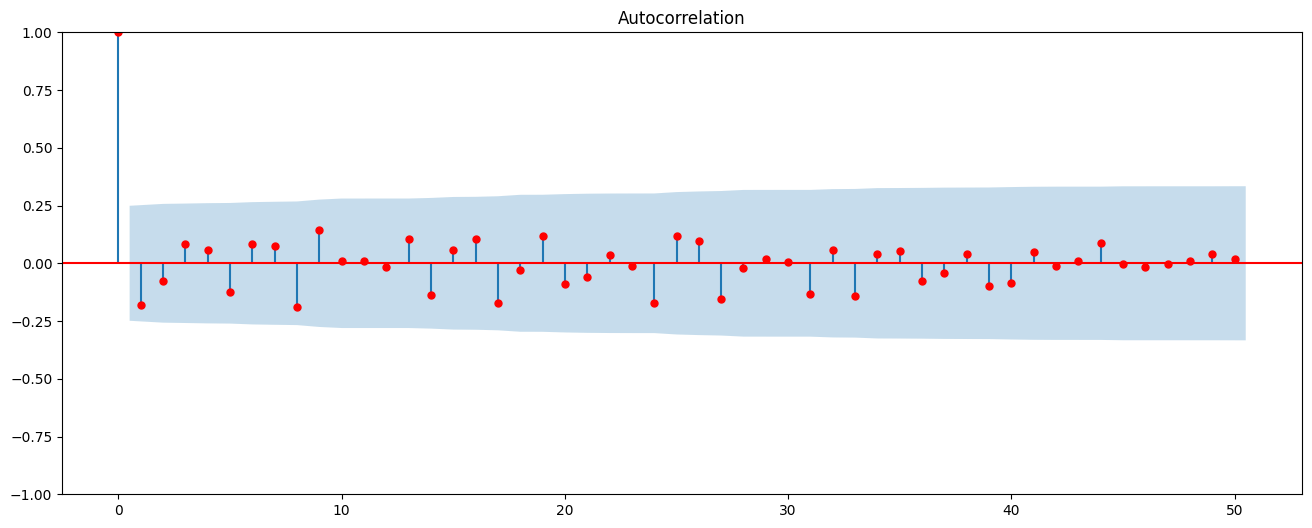

In [8]:
g = plot_acf(tr10_yield_annual, lags=50, color="red", alpha=0.05).set_size_inches(16, 6)

## <font face="gotham" color="purple"> Does White Noise Have Autocorrelation?</font>

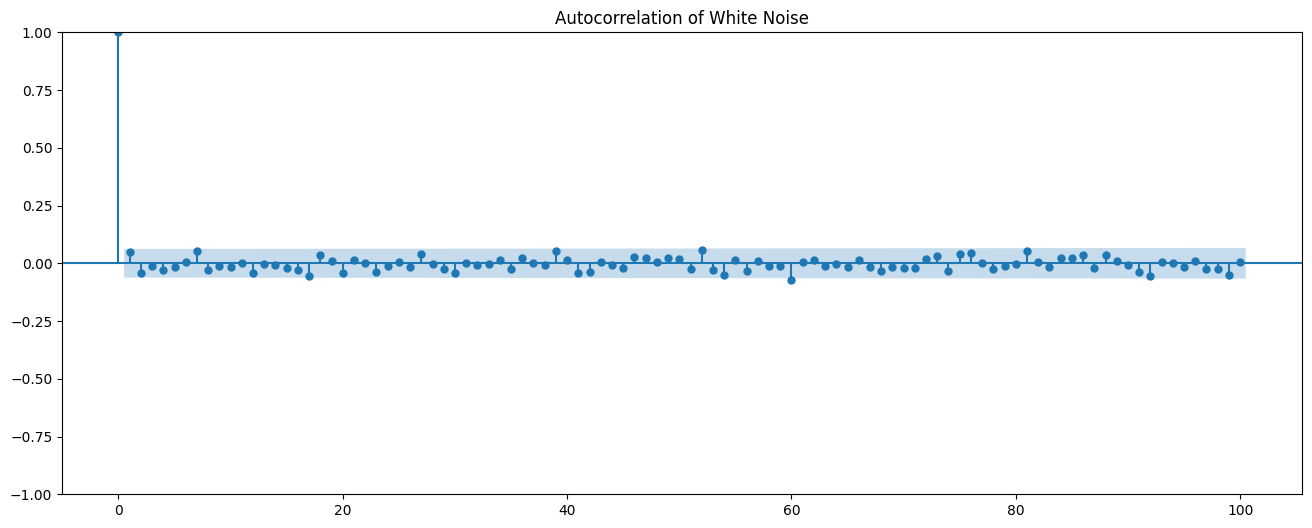

In [9]:
white_noise = np.random.randn(1000)
g = plot_acf(
    white_noise, lags=100, title="Autocorrelation of White Noise"
).set_size_inches(16, 6)

Stocks price are random walk, but the returns are usually white noises, so we can't use any models to predict returns of stock prices. 

## <font face="gotham" color="purple"> Seasonality And Autocorrelation </font>

[*********************100%%**********************]  1 of 1 completed


array([<Axes: xlabel='Date'>], dtype=object)

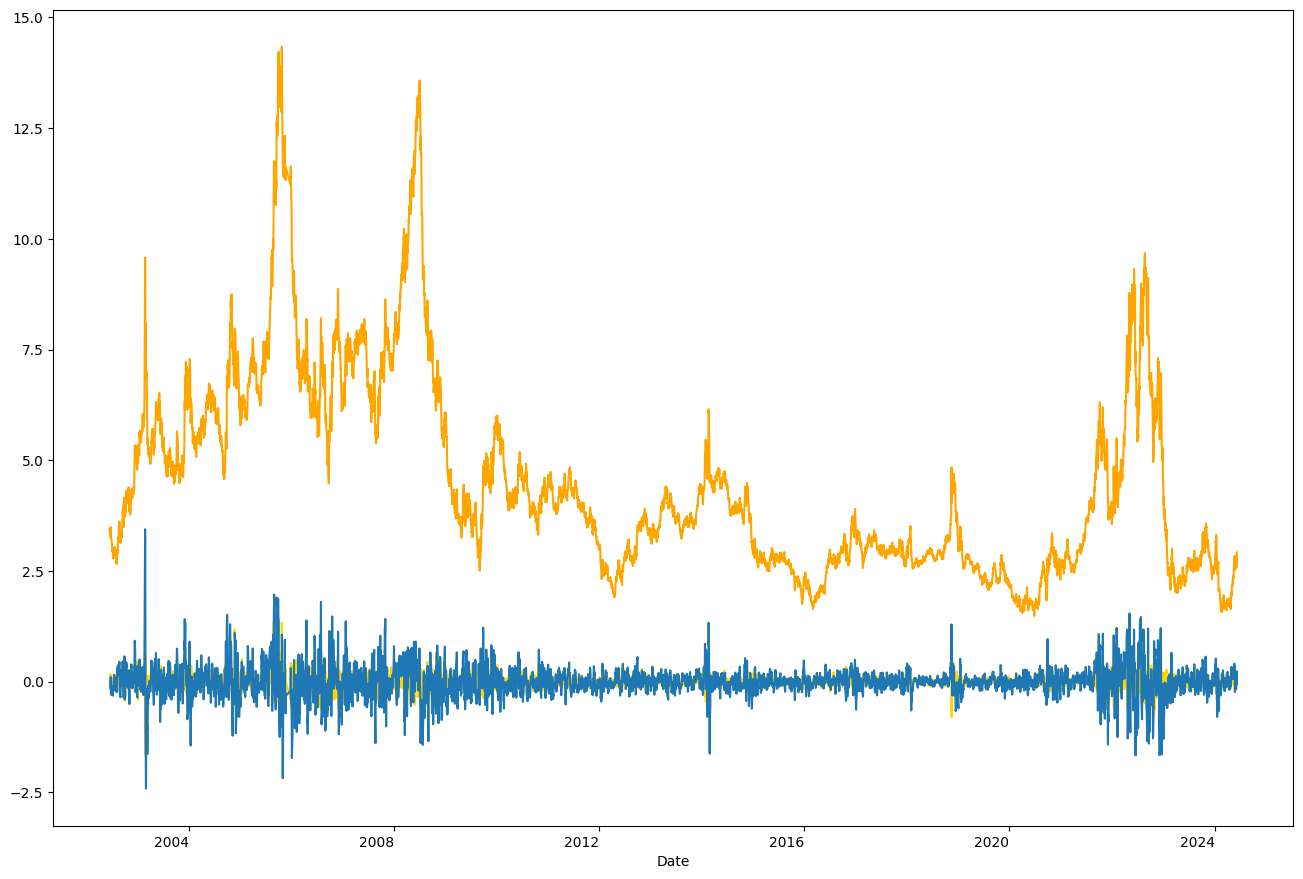

In [10]:
electric_gas = yf.download("QG=F", start=start)["Adj Close"].dropna()

# Calculate the differences
electric_gas_diff1 = electric_gas.diff()
electric_gas_diff2 = electric_gas.diff(4)

# Plot the data
electric_gas.plot(figsize=(16, 12), subplots=True, color='orange')
electric_gas_diff1.plot(figsize=(16, 12), subplots=True, color='gold')
electric_gas_diff2.plot(figsize=(16, 12), subplots=True)

If you have seasonal data, first order difference won't work, have to use the fourth order difference.

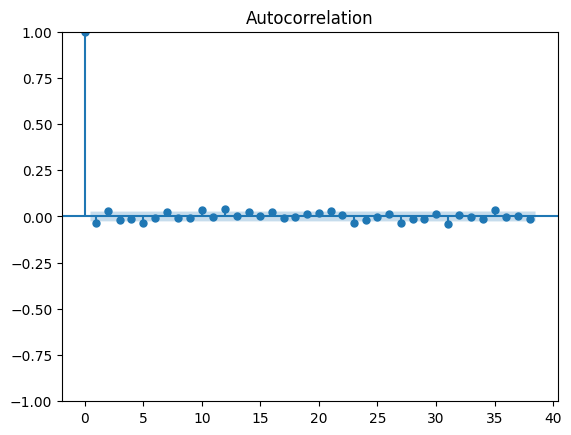

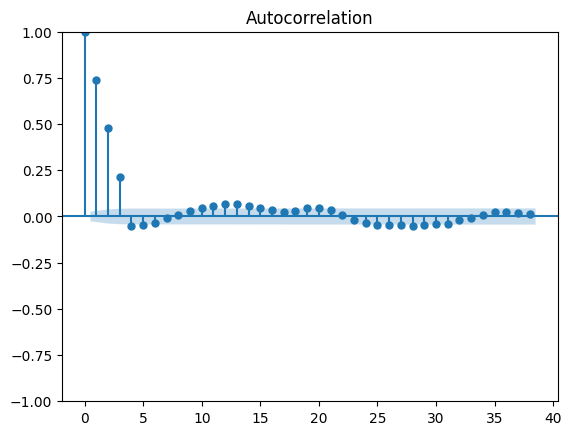

In [11]:
g1 = plot_acf(electric_gas_diff1.dropna())
g2 = plot_acf(electric_gas_diff2.dropna())

## <font face="gotham" color="purple"> AR And MA Processes </font>

If the disturbance term is generated by the process
$$
u_{t}=\rho u_{t-1}+\varepsilon_{t} \quad-1<\rho<1
$$
we call it a **First-Order Autoregression Process**, denoted $AR(1)$. And **innovation** $\varepsilon_{t}$ satisfies standard features of OLS disturbance term as below, and $\rho$ is coefficient of autocorrelation at lag $1$
$$
\begin{aligned}
E\left(\varepsilon_{t}\right) &=0 \\
\operatorname{Var}\left(\varepsilon_{t}\right) &=\sigma_{\varepsilon}^{2} \\
\operatorname{Cov}\left(\varepsilon_{t}, \varepsilon_{t+s}\right) &=0 \quad s \neq 0
\end{aligned}
$$
If $|\rho|<1$ we say that $AR(1)$ process is **stationary**, we'll get back to this topic in more details.

The main alternative is **moving average model** which is a weighted sum of current and previous values of $\varepsilon$'s, for instance $MA(2)$ is
$$
u_t = \lambda_0 \varepsilon_t+ \lambda_1 \varepsilon_{t-1}+ \lambda_2 \varepsilon_{t-2}
$$

# <font face="gotham" color="purple">Causes Of Autocorrelation</font>

## <font face="gotham" color="purple"> Model Misspecification</font>

In [12]:
df = pd.read_excel(
    "Basic_Econometrics_practice_data.xlsx", sheet_name="Mortality_NI_WB_2019"
)
df.head()
df_mort = df[df["Series_Name"] == "mortality_rate_per_1000"]
df_NI = df[df["Series_Name"] == "NI_perCap_2010constUSD"]

In [13]:
reg_results = sp.stats.linregress(df_NI[2019], df_mort[2019])
Y_fit = reg_results[1] + reg_results[0] * df_NI[2019]
residuals = np.asarray(df_mort[2019]) - np.asarray(Y_fit)

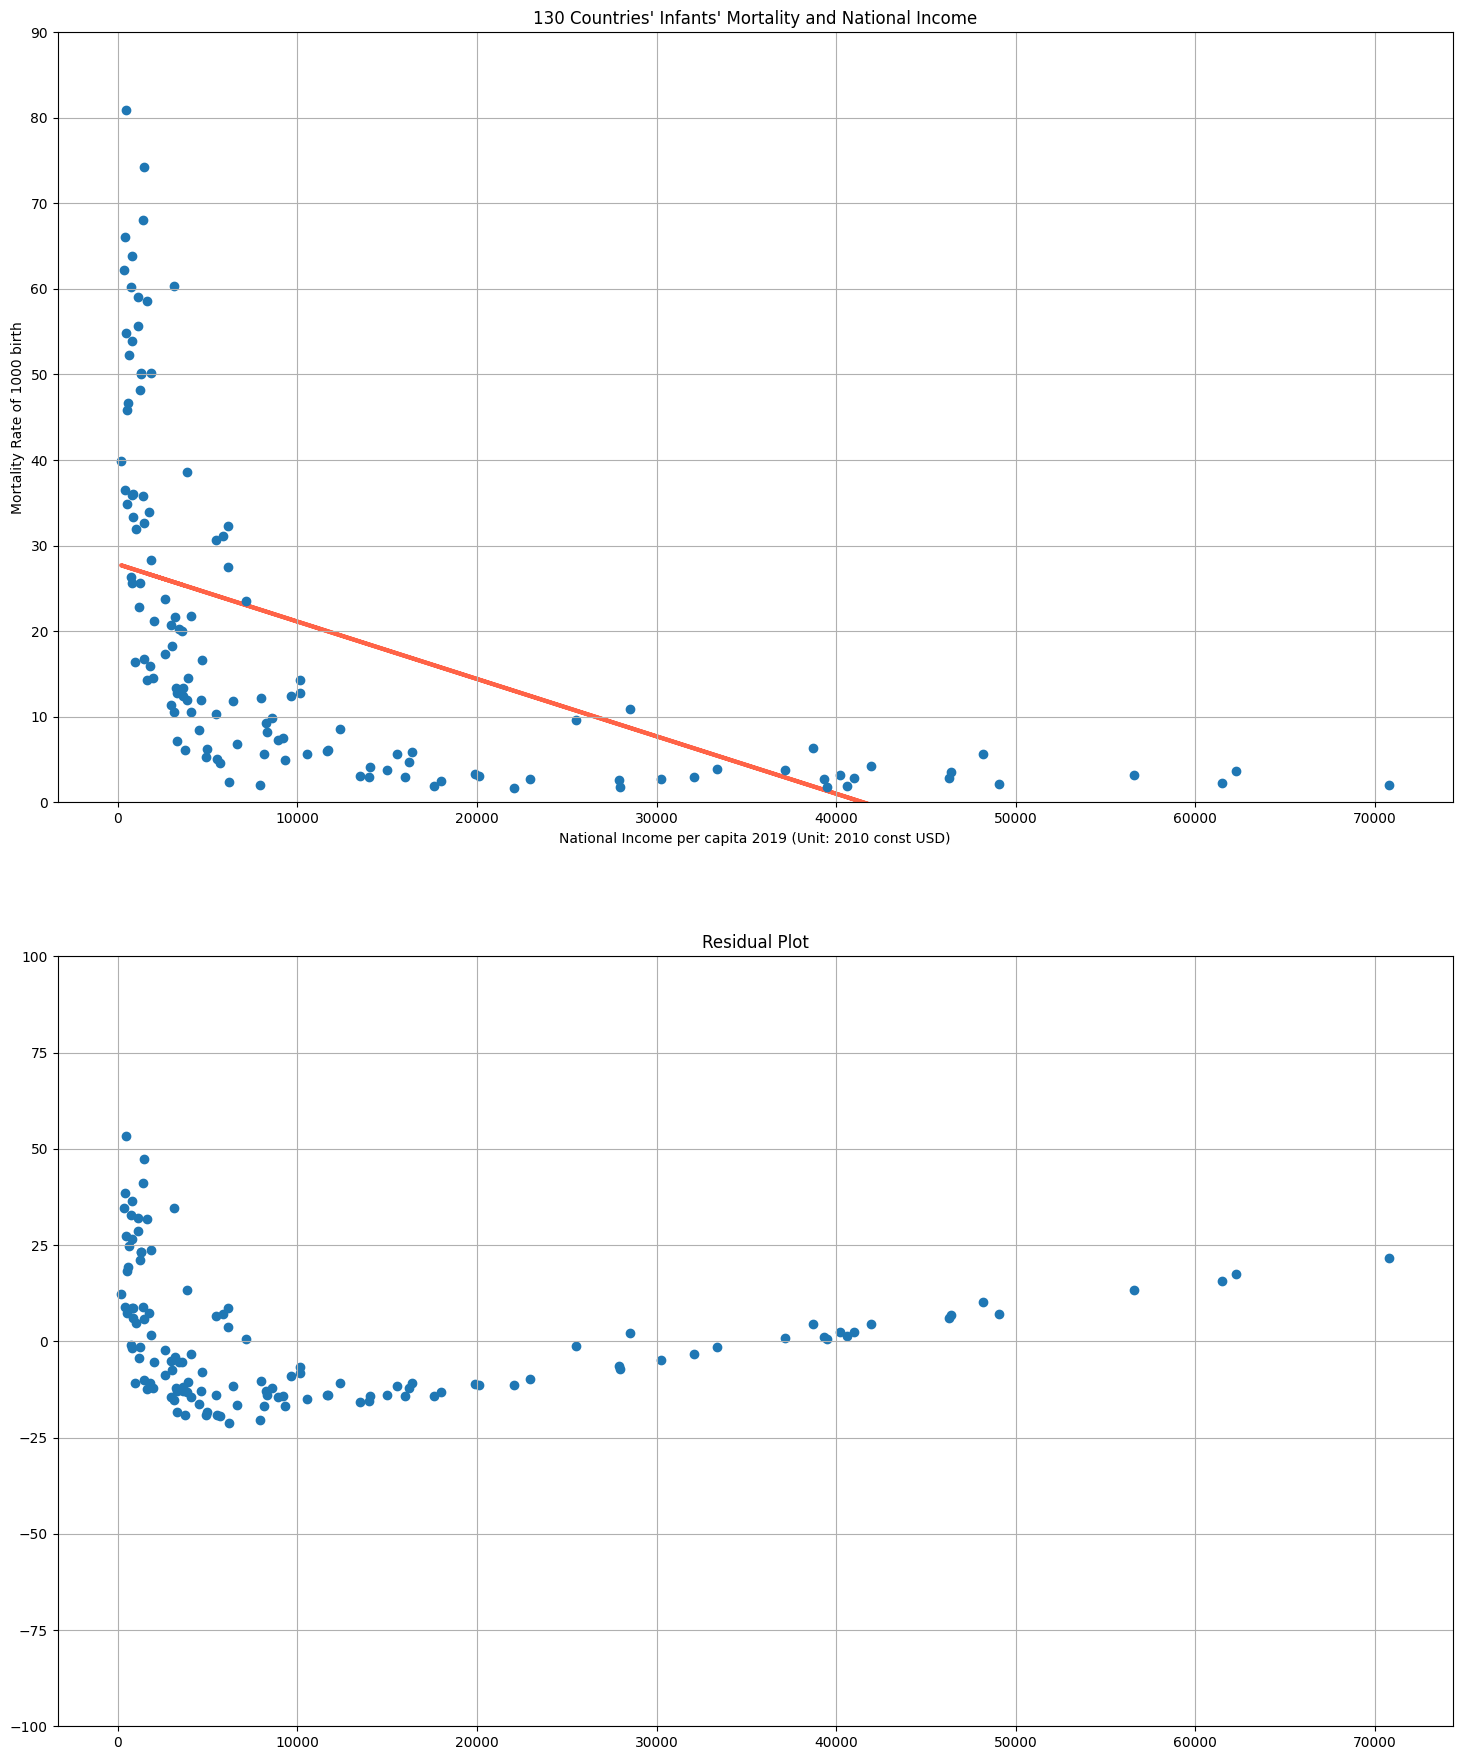

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 22))
ax[0].scatter(df_NI[2019], df_mort[2019])
ax[0].plot(df_NI[2019], Y_fit, color="tomato", lw=3, zorder=0)
ax[0].set_xlabel("National Income per capita 2019 (Unit: 2010 const USD)")
ax[0].set_title("130 Countries' Infants' Mortality and National Income")
ax[0].set_ylabel("Mortality Rate of 1000 birth")
ax[0].set_ylim([0, 90])
ax[0].grid()

ax[1].scatter(df_NI[2019], residuals)
ax[1].set_ylim([-100, 100])
ax[1].grid()
ax[1].set_title("Residual Plot")
plt.show()

## <font face="gotham" color="purple"> Omitted Variable Bias</font>

Be aware low $dw$ test might signal the omission of variable, but not vice versa, we can demonstrate with Monte Carlo simulation.

In [15]:
N = 100
beta1, beta2, beta3 = 3, 4, 5
X2 = np.arange(N)
dw_array_omit_X2, dw_array_omit_X3, dw_array = [], [], []
for i in range(10000):
    u = np.random.randn(N)
    X3 = np.random.rand(N)
    Y = beta1 + beta2 * X2 + beta3 * X3 + u
    df = pd.DataFrame([Y, X2, X3]).T
    df.columns = ["Y", "X2", "X3"]
    model = smf.ols(formula="Y ~ X2", data=df)
    results = model.fit()
    dw_array_omit_X3.append(dw_test(results.resid))

    model = smf.ols(formula="Y ~ X3", data=df)
    results = model.fit()
    dw_array_omit_X2.append(dw_test(results.resid))

    model = smf.ols(formula="Y ~ X2 + X3", data=df)
    results = model.fit()
    dw_array.append(dw_test(results.resid))

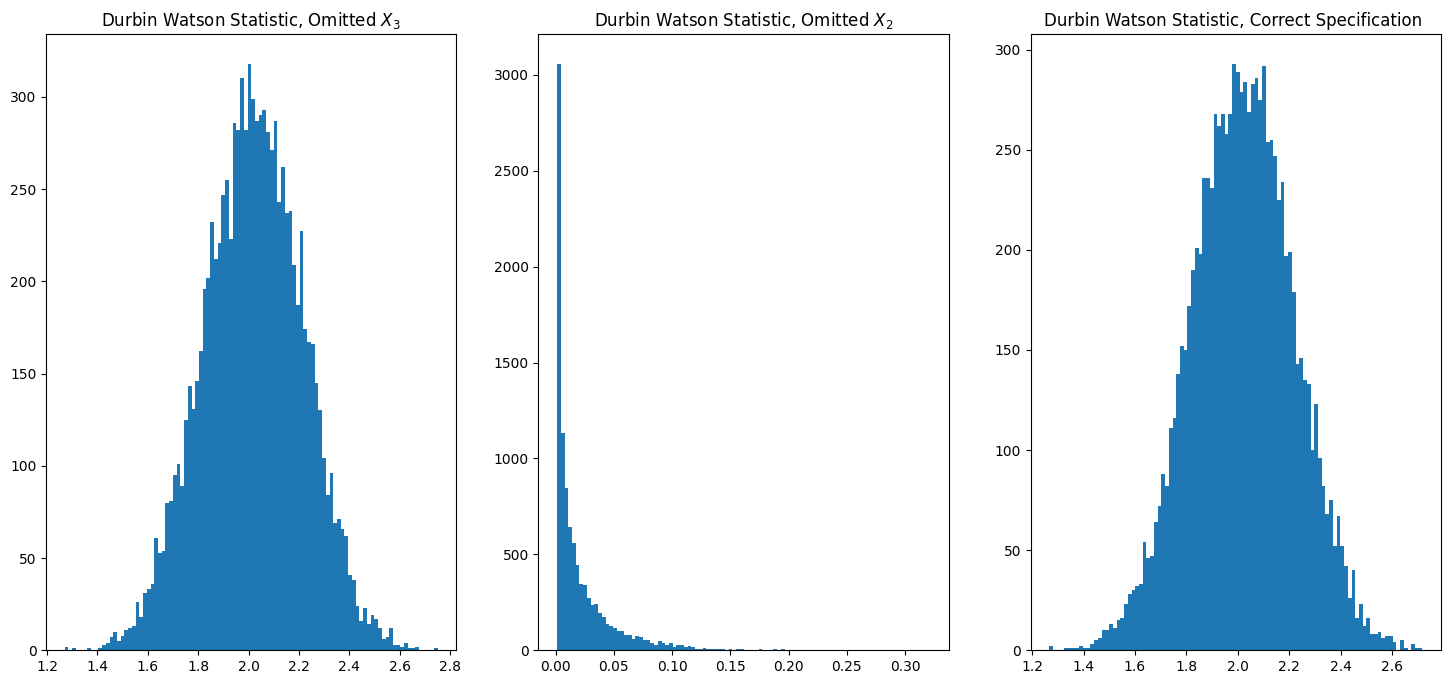

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
ax[0].hist(dw_array_omit_X3, bins=100)
ax[0].set_title("Durbin Watson Statistic, Omitted $X_3$")
ax[1].hist(dw_array_omit_X2, bins=100)
ax[1].set_title("Durbin Watson Statistic, Omitted $X_2$")
ax[2].hist(dw_array, bins=100)
ax[2].set_title("Durbin Watson Statistic, Correct Specification ")
plt.show()

# <font face="gotham" color="purple"> OLS Estimation With Presence Of Autocorrelation </font>

As in the case of heteroscedasticity, in the presence of autocorrelation the OLS estimatorsare still linear unbiased as well as consistent and asymptotically normally distributed, but they are no longer efficient (i.e., minimum variance).

First use a $AR(1)$ model to generate an autocorrelated series as our disturbance term
$$
u_{t}=\rho u_{t-1}+\varepsilon_{t}
$$
choose any $\rho$ fits your preference, here I use $.98$ 

In [17]:
T = 100
epsilon = 10 * np.random.randn(T)
u = [100]
u_current = u[0]
rho = 0.98
for i in epsilon:
    u_next = rho * u_current + i
    u.append(u_next)
    u_current = u_next
u = u[1:]

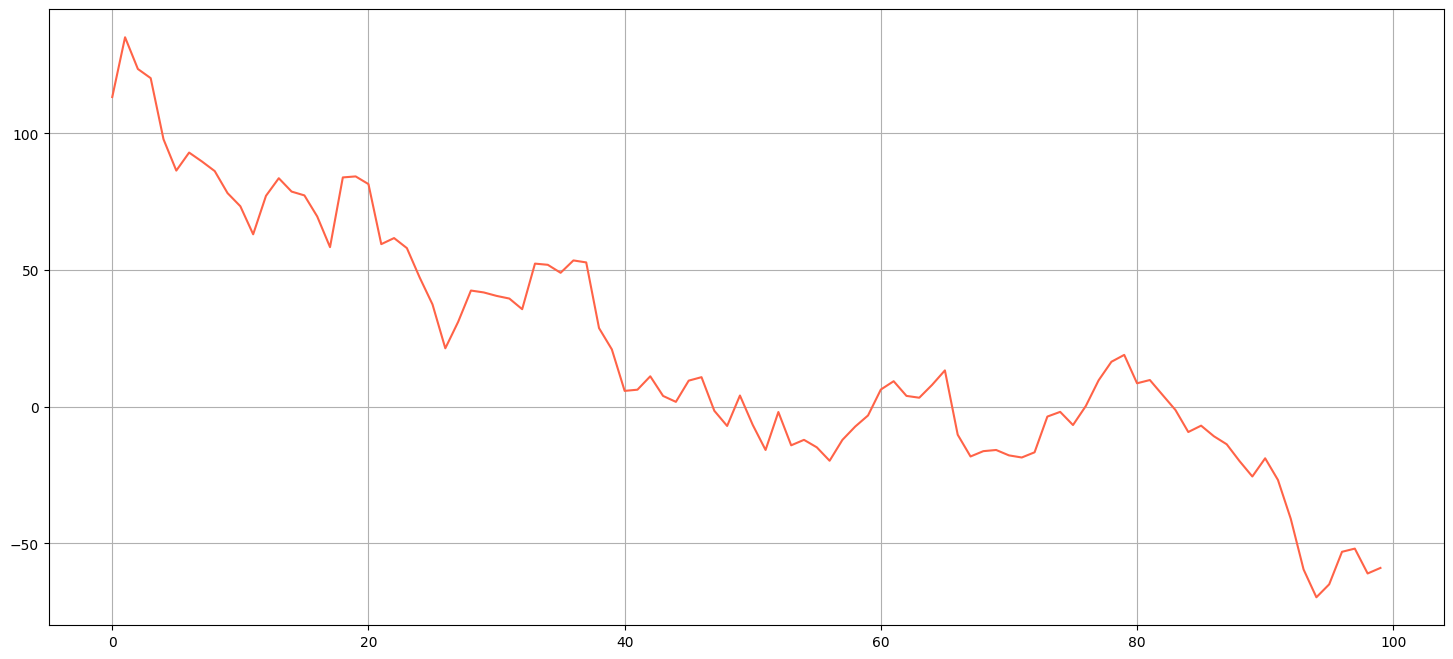

In [18]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(u, color="tomato")
ax.grid()
plt.show()

Then assume $X$ fixed at $1, 2, 3,..., T$ and define a true relationship as
$$
Y_t = 2 + 3 X_t + u_t
$$

In [19]:
X = np.arange(1, T + 1)
Y = 2 + 3 * X + u
PRF = 2 + 3 * X
df = pd.DataFrame([X, Y]).T
df.columns = ["X", "Y"]

In [20]:
model = smf.ols(formula="Y ~ X", data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     572.5
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           1.04e-42
Time:                        19:36:44   Log-Likelihood:                -435.37
No. Observations:                 100   AIC:                             874.7
Df Residuals:                      98   BIC:                             879.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     94.0287      3.830     24.550      0.0

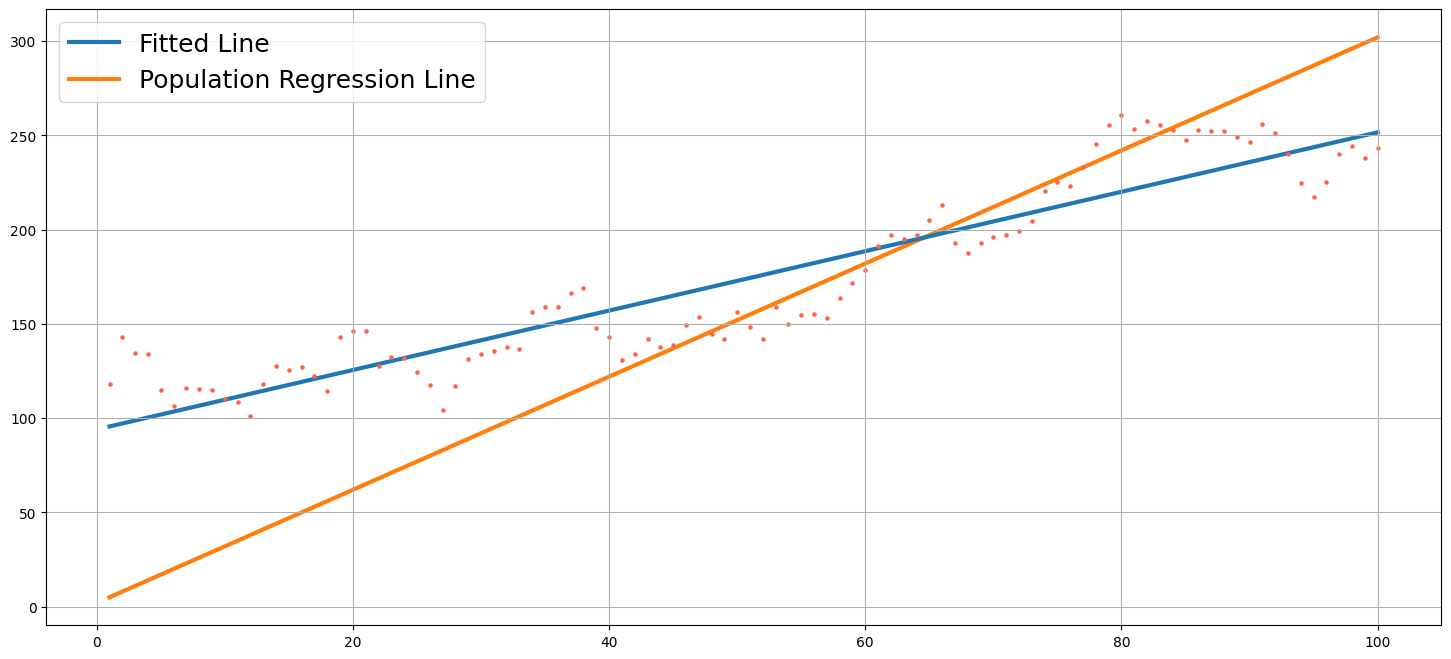

In [21]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.scatter(X, Y, color="tomato", s=5)
ax.plot(X, results.fittedvalues, label="Fitted Line", lw=3, zorder=0)
ax.plot(X, PRF, label="Population Regression Line", lw=3, zorder=-1)
ax.grid()
ax.legend(prop={"size": 18})
plt.show()

You would be surprised to see that true relationship (Population Regression Function) deviates much more than fitted line, it is exactly due to autocorrelation, as $\rho$ getting smaller, the generated dots will be closer to PRF, therefore fitted line will be closer to PRF as well.

The point is that with presence of autocorrelation, the estimation results will vary wildly from true relationship, hence all hypothesis tests are invalid too. This happens very common in time series estimation.

# <font face="gotham" color="purple"> Detection of Autocorrelation </font>

## <font face="gotham" color="purple"> Graphical Method </font>

Though the non-autocorrelation assumption relates to disturbance term $u_t$, which are unobservable, we can instead visualize the residuals $e_t$. Very likely residuals can provide useful information when demonstrating a visual examination.

Here is a simulated residuals from example above, though graphical method is subjective and qualitative, you can still draw to a rough conclusion if you see an patter presence in residuals.

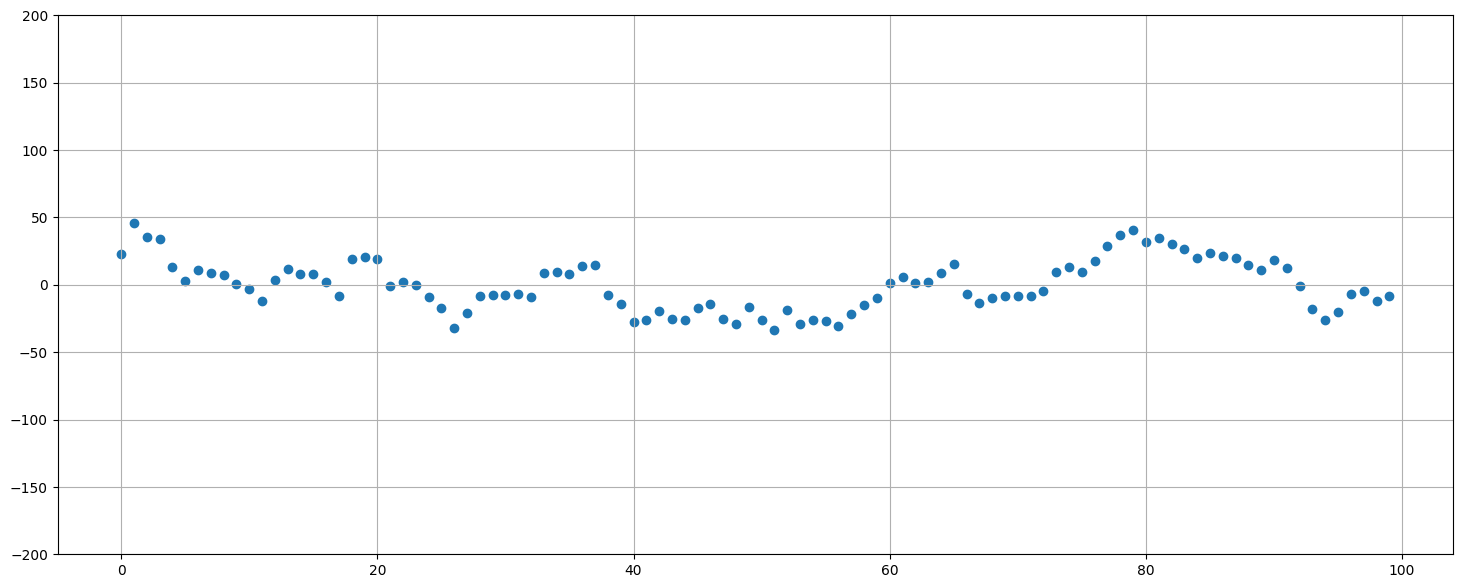

In [22]:
fig, ax = plt.subplots(figsize=(18, 7))
ax.scatter(np.arange(len(results.resid)), results.resid)
ax.set_ylim([-200, 200])
ax.grid()
plt.show()

## <font face="gotham" color="purple"> Durbin-Watson Test </font>

The standard test for first order autocorrelation is **Durbin-Watson Test**, it is one of standard output of OLS estimation. It is calculated by the formula
$$
dw=\frac{\sum_{t=2}^{T}\left(e_{t}-e_{t-1}\right)^{2}}{\sum_{t=1}^{T} e_{t}^{2}}
$$

where $e_t$ is residual at time $t$. 

As an example, we can reproduce the OLS estimation of disposable income and house price in China. 

In [23]:
df = pd.read_excel(
    "Basic_Econometrics_practice_data.xlsx", sheet_name="CN_Cities_house_price"
)
model = smf.ols(formula="house_price ~ salary", data=df)
results = model.fit()

from statsmodels.stats.stattools import durbin_watson as dw_test

dw_test(results.resid)

0.9255117521586897

Or we can write our own Durbin-Watson function to verify the results

In [24]:
def durbin_watson_test(series):
    nomin = np.sum((series[1:] - series.shift(1).dropna()) ** 2)
    denom = np.sum(series**2)
    return nomin / denom


durbin_watson_test(results.resid)

0.9255117521586897

But how to interpret this number? Some mathematical manipulations of Durbin-Watson's statistic will bring some insight
$$
dw=\frac{\sum_{t=2}^{T}\left(e_{t}-e_{t-1}\right)^{2}}{\sum_{t=1}^{T} e_{t}^{2}} = \frac{\sum_{t=2}^{T}\left(e^2_{t}-2e_te_{t-1}+e^2_{t-1}\right)}{\sum_{t=1}^{T} e_{t}^{2}} = \frac{\sum_{t=1}^Te_t^2}{\sum_{t=1}^Te_t^2}+\frac{\sum_{t=1}^Te_{t-1}^2}{\sum_{t=1}^Te_t^2}-2\frac{\sum_{t=1}^Te_te_{t-1}}{\sum_{t=1}^Te_t^2}
$$

If $T\rightarrow \infty$, the second term approaches $1$ infinitely and the third term $\frac{\sum_{t=1}^Te_te_{t-1}}{\sum_{t=1}^Te_t^2}$ equals $\rho$, because it is a simple OLS estimator of $\rho$. 

Therefore $dw \rightarrow 2-2\rho$ given $T\rightarrow \infty$.



If no autocorrelation, $\rho=0$, $dw$ should be $2$, if $\rho > .5$, i.e. strong positive autocorrelation, $dw$ will be close to $0$, or if $\rho>-.5$, i.e. strong negative autocorrelation, $dw$ will be close to $4$.

Because $dw$ statistic doesn't have critical value (due to some technical reason, critical value can't be calculated.) However, it is possible to know the upper and lower limit of $dw$, go search _Durbin Watson table_ on Google and click any of image that shows on top, or click <a href='https://www.real-statistics.com/statistics-tables/durbin-watson-table/'>here</a>.

In the data of flat price, number of observations is $25$ and number of independent variables is $1$, here are upper and lower limit from the table.
$$
d_L = 1.055\\
d_U = 1.210
$$
Our result $dw=0.9255$ is lower than lower limit, which suggests a rejection of null hypothesis $\rho=0$, why? Because it's too far away from $2$, if $dw$ is larger than upper limit, we fail to reject null hypothesis. If the $dw$ drops between lower and upper limit, just forget about it, no decisive conclusion. 

However, keep in mind that autocorrelation can also be attributed to model specification errors and we almost only care about autocorrelation issue in time series rather than cross sectional data.

Here is an example of exchange rate $EUR/USD$.

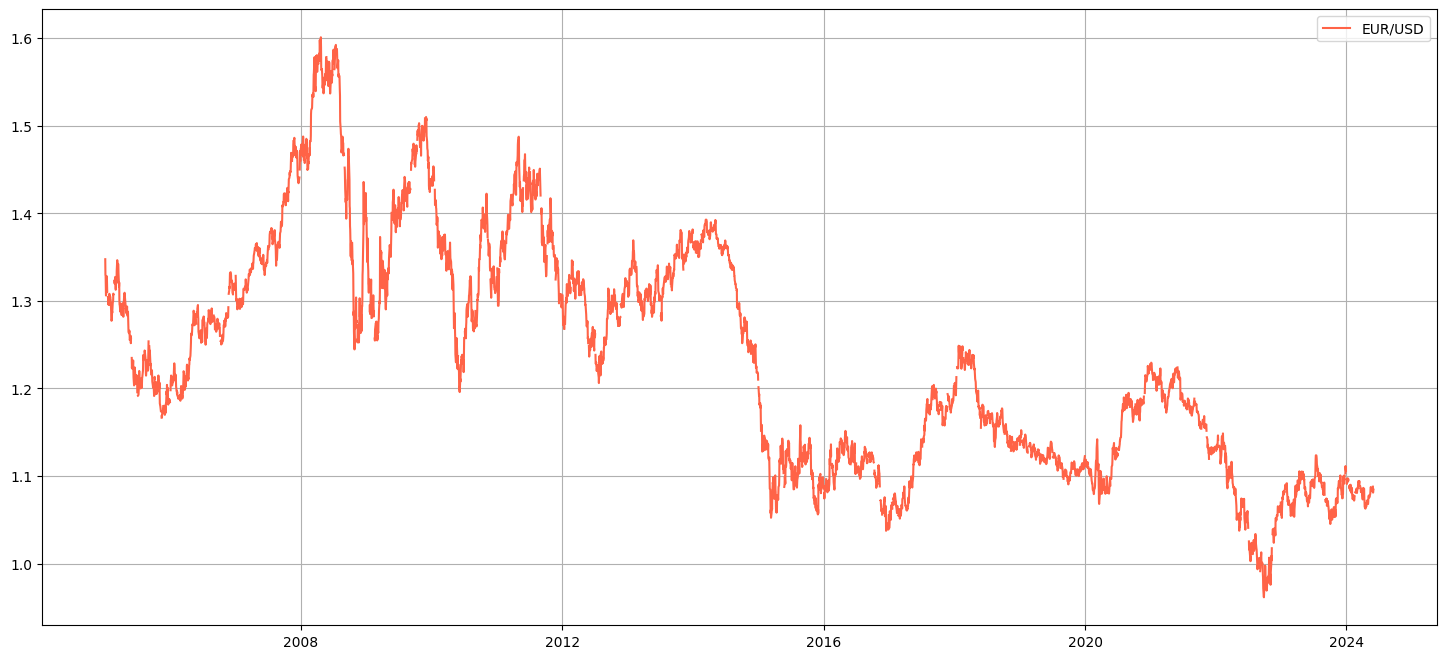

In [25]:
start = dt.datetime(2005, 1, 1)
end = dt.datetime.today()
EURUSD = fred.get_series('DEXUSEU', start, end)

fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(EURUSD, color="tomato", label="EUR/USD")
ax.legend()
ax.grid()
plt.show()

In [26]:
durbin_watson_test(EURUSD)

3.12645076860537e-05

The $dw$ statistic is literally $0$, which means $\rho=1$, this shouldn't be a shocking result. Most of time sereis of assets price will show a strong first degree autocorrelation, this is why we like trading the trend or momentum. 

However, $dw$ test is mostly for testing residuals, here's another example that demonstrating highly autocorrelated residuals.

In [27]:
start = dt.datetime(2005, 1, 1)
end = dt.datetime.today()


real_GDP_perCap = fred.get_series('A939RX0Q048SBEA', start, end)
priv_resid_fixInv = fred.get_series('PRFI', start, end)
df = pd.DataFrame({
    'real_GDP_perCap': real_GDP_perCap,
    'priv_resid_fixInv': priv_resid_fixInv
})

In [28]:
model = smf.ols(formula="real_GDP_perCap ~ priv_resid_fixInv", data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        real_GDP_perCap   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     163.0
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           1.72e-20
Time:                        19:37:11   Log-Likelihood:                -707.73
No. Observations:                  77   AIC:                             1419.
Df Residuals:                      75   BIC:                             1424.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          4.836e+04    840.78

The drawback of $dw$ test is that it assumes nonstachastic regressors (or independent variables we call in previous contexts), i.e. the regressors are fixed in repeated sampling. Then this drawback would invalidate the power of $dw$ test in time series modelling. 

## <font face="gotham" color="purple"> Breusch–Godfrey Test </font>

The Breusch–Godfrey Test is more general than Durbin-Watson that it allows for higher autoregression schemes and higher order of moving averages of white noises. 

Suppose disturbance terms are generated by an $AR(3)$ process
$$
u_{t}=\rho_1 u_{t-1}+\rho_2 u_{t-2}+\rho_3 u_{t-3}+\varepsilon_{t}
$$
and choose whatever $\rho$'s you like. $\varepsilon_t$ follows classical linear regression assumption.

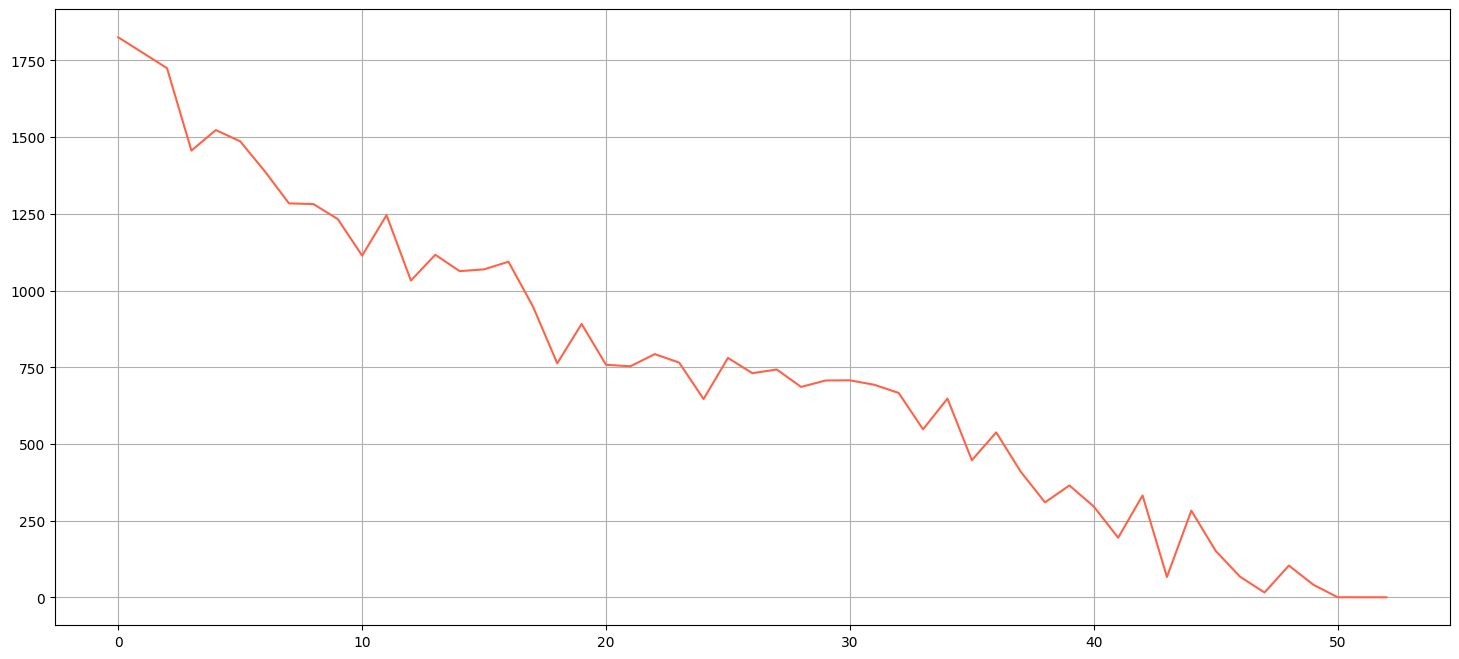

In [29]:
T = 50
u = np.array([0.5, 0.45, 0.4])
rho_array = np.array([0.5, 0.4, 0.2])
for i in range(T):
    u_new_element = np.dot(u[:3], rho_array) + 100 * np.random.randn()
    u = np.append(u_new_element, u)

fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(u, color="tomato")
ax.grid()
plt.show()

In [30]:
X = np.arange(1, len(u) + 1)
Y = 2 + 3 * X + u
PRF = 2 + 3 * X
df = pd.DataFrame([X, Y]).T
df.columns = ["X", "Y"]

In [31]:
model = smf.ols(formula="Y ~ X", data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     957.2
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           1.02e-34
Time:                        19:37:11   Log-Likelihood:                -319.97
No. Observations:                  53   AIC:                             643.9
Df Residuals:                      51   BIC:                             647.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1604.3103     28.779     55.747      0.0

Once you have residual, run auxiliary regression
$$
\hat{u}_{t}=\alpha_{1}+\alpha_{2} X_{t}+\hat{\rho}_{1} \hat{u}_{t-1}+\hat{\rho}_{2} \hat{u}_{t-2}+\cdots+\hat{\rho}_{p} \hat{u}_{t-p}+\varepsilon_{t}
$$

Use the coefficient of determinant to construct the statistic 
$$
(n-p) R^{2} \sim \chi_{p}^{2}
$$
where $p$ is the number of lags, $n$ is the number of observations.

Fortunately, ```statsmodels``` has Breusch-Godfrey function, the first value is the test statistic and the second is the $p$-value.

In [32]:
import statsmodels.stats.diagnostic as dg

print(dg.acorr_breusch_godfrey(results, nlags=3))

(15.395020146240233, 0.0015083813366996376, 6.5502048744008805, 0.000839352599895712)


# <font face="gotham" color="purple"> Remedies For Autocorrelaton </font>

If we know $\rho$'s, it would be easy to convert to a **generalized difference equation** form
$$
\left(Y_{t}-\rho Y_{t-1}\right)=\beta_{1}(1-\rho)+\beta_{2}\left(X_{t}-\rho X_{t-1}\right)+\varepsilon_{t}
$$
such that disturbance term now is $\varepsilon_t$, which satisfied classical OLS assumption.

However, we rarely know true value of $\rho$'s.

If you have no information of $\rho$, the best guess is by check $dw$ test, if 
$$
dw < R^2
$$
We assume $\rho =1$, then generalized difference equations becomes
$$
Y_{t}- Y_{t-1}=\beta_{2}(X_{t}-X_{t-1})+\varepsilon_{t}
$$
or 
$$
\Delta Y_{t}=\Delta \beta_{2}X_{t}+\varepsilon_{t}
$$

If you don't want to guess or simply using first order difference, the best choice is to estimate $\rho$ in model
$$
e_{t}=\rho \cdot e_{t-1}+v_{t}
$$
where $e$'s are residuals. 

Because $\rho$'s are estimates, we usually call these procedures the **feasible generalized least squares** (FGLS). 

Instead of using FGLS, we have **HAC (heteroscedasticity- and autocorrelation-consistent) standard errors** (some textbooks call it Newey-West standard errors).

In [33]:
model = smf.ols(formula="Y ~ X", data=df)
results = model.fit(cov_type="HAC", cov_kwds={"maxlags": 1})
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     549.4
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           5.72e-29
Time:                        19:37:11   Log-Likelihood:                -319.97
No. Observations:                  53   AIC:                             643.9
Df Residuals:                      51   BIC:                             647.9
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1604.3103     45.544     35.225      0.0

In small samples, FGLS and HAC are not better than OLS, by small samples, we mean a sample less than $30$ observation.